<h1 style="background-color:red;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Corona Tweet Analysis</h1>


<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Importing Library and Data</h1>


In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
import keras
from keras.layers import Dense,LSTM,Embedding,Input,GlobalMaxPool1D
from keras.models import Sequential
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
warnings.filterwarnings('ignore')


Using TensorFlow backend.
C:\Users\abhij\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\abhij\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\abhij\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\abhij\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data=pd.read_csv('Corona_NLP_train.csv',encoding='latin1',parse_dates=['TweetAt'])
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
data.describe(include='O')

,Location,OriginalTweet,Sentiment
count,32567,41157,41157
unique,12220,41157,5
top,London,Staying home is the best way that we can slow ...,Positive
freq,540,1,11422


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
data.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## There is very high probability that 'Extremely postivie' or 'Extremely Negative' would be mispredicted as 'Postive' or 'Negative', or vice-versa. Because words used in those tweets are very much similiar to each other. So in order to avoid these types of confusion we could assign them same.

In [6]:
data.Sentiment=data.Sentiment.replace({'Extremely Positive':'Positive','Extremely Negative':'Negative'})

In [7]:
train_text,val_text,train_label,val_label=train_test_split(data.OriginalTweet,data.Sentiment,
                                                             test_size=0.15,random_state=42)

In [8]:
lbl_encoder=LabelEncoder()
train_label_codes=lbl_encoder.fit_transform(train_label)

In [9]:
lbl_encoder.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [10]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        sentence=re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sentence)
        sentence=re.sub('[^0-9a-z]',' ',sentence)
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>1]

<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Two Processes to predict our required classes</h1>


<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Process 1</h1>


In [11]:
tokenizer=CountVectorizer(max_features=5000,stop_words='english',lowercase=True,tokenizer=Lemmatizer())


In [12]:
train_x=tokenizer.fit_transform(train_text).toarray()

In [13]:
tokenizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <__main__.Lemmatizer at 0x161af78a408>,
 'vocabulary': None}

In [14]:
feature_names=tokenizer.get_feature_names()

In [15]:
val_x=tokenizer.transform(val_text).toarray()
val_label_codes=lbl_encoder.transform(val_label)

In [16]:
from sklearn.linear_model import LogisticRegression
model_p1=LogisticRegression()
model_p1.fit(train_x,train_label_codes)

LogisticRegression()

In [17]:
print('Validation classification report',classification_report(val_label_codes,model_p1.predict(val_x)))
print('Training classification report',classification_report(train_label_codes,model_p1.predict(train_x)))

Validation classification report               precision    recall  f1-score   support

           0       0.81      0.79      0.80      2306
           1       0.69      0.72      0.70      1176
           2       0.83      0.83      0.83      2692

    accuracy                           0.79      6174
   macro avg       0.78      0.78      0.78      6174
weighted avg       0.79      0.79      0.79      6174

Training classification report               precision    recall  f1-score   support

           0       0.90      0.89      0.89     13092
           1       0.82      0.84      0.83      6537
           2       0.91      0.91      0.91     15354

    accuracy                           0.89     34983
   macro avg       0.88      0.88      0.88     34983
weighted avg       0.89      0.89      0.89     34983



<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Data Visualization</h1>

In [18]:
data.Sentiment=lbl_encoder.transform(data.Sentiment)

In [19]:
df=data.set_index('TweetAt').resample('W').count()

[]

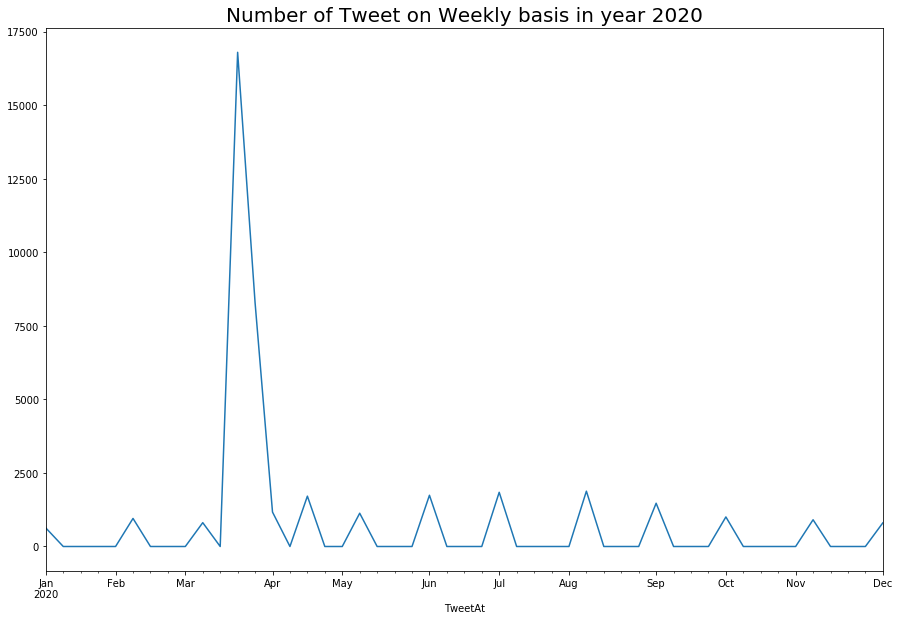

In [20]:
plt.figure(figsize=(15,10))
df['OriginalTweet'].plot()
plt.title('Number of Tweet on Weekly basis in year 2020',fontdict={'size':'20'})
plt.plot()

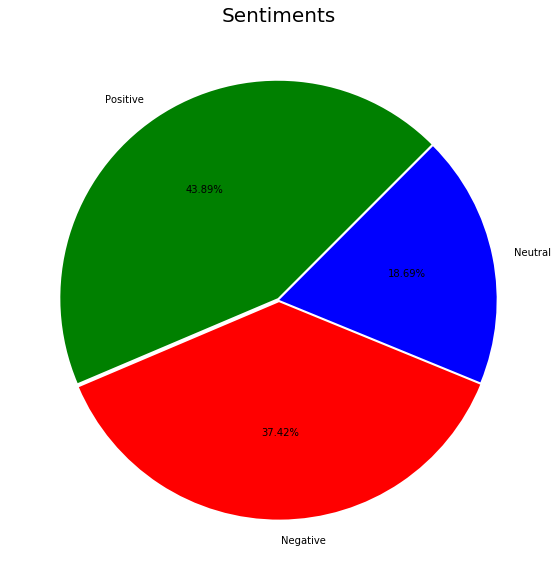

In [21]:
plt.figure(figsize=(15,10))
plt.pie(train_label.value_counts(),explode=[0.01,0.01,0.001],colors=['green','red','blue'],
        labels=['Positive','Negative','Neutral'],autopct='%0.2f%%',radius=1,startangle=45)
plt.title('Sentiments',fontdict={'size':'20'})
plt.show()

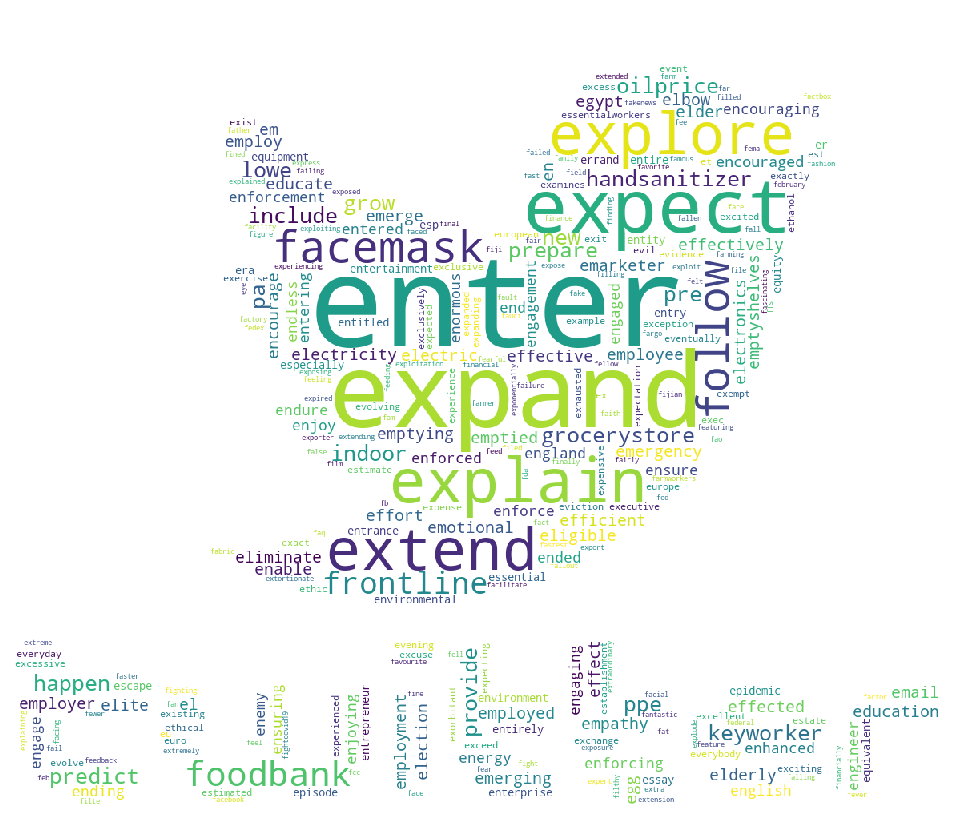

In [23]:
twitter_mask=np.array(Image.open('twitter.png'))
wc=WordCloud(max_words=300,mask=twitter_mask,background_color='white')
wc.generate(' '.join(word for word in feature_names[1500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

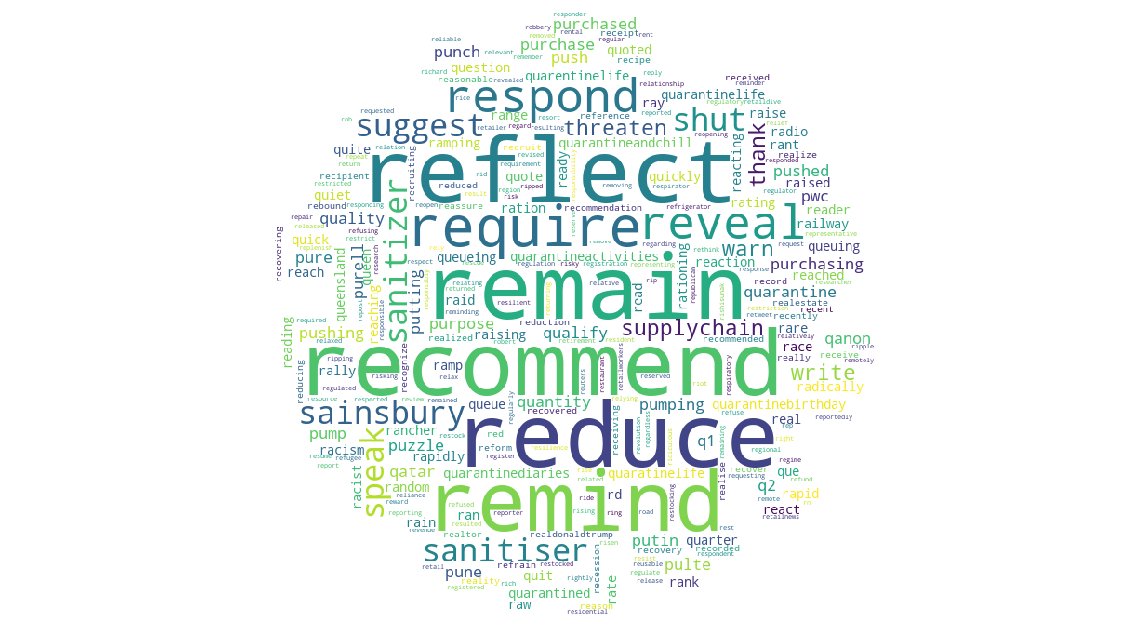

In [24]:
corona_mask=np.array(Image.open('coronav.jpg'))
wc_corona=WordCloud(max_words=300,mask=corona_mask,background_color='white')
wc_corona.generate(' '.join(word for word in feature_names[3500:] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc_corona)

<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Process 2</h1>


In [25]:
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
reduceLR=ReduceLROnPlateau(monitor='val_accuarcy',patience=2)

In [26]:
token=Tokenizer(num_words=5000,oov_token=Lemmatizer())
token.fit_on_texts(train_text)
train_x_2=token.texts_to_sequences(train_text)
train_x_2=pad_sequences(train_x_2,maxlen=60,padding='post',truncating='post')

In [27]:
val_x_2=token.texts_to_sequences(val_text)
val_x_2=pad_sequences(val_x_2,maxlen=60,padding='post',truncating='post')

In [30]:
embedding_dimension=32
v=len(token.word_index)
model=Sequential()
model.add(Embedding(v+1,embedding_dimension,input_shape=(60,)))
# model.add(Input(shape=(train_x.shape[1],)))
model.add(LSTM(64,return_sequences=True))
# model.add(Dense(128))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Dense(3,activation='softmax'))

In [31]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
r=model.fit(train_x_2,train_label_codes,validation_data=(val_x_2,val_label_codes),
            epochs=20,batch_size=50,callbacks=[reduceLR,early_stop])


Train on 34983 samples, validate on 6174 samples
Epoch 1/20
34983/34983 [==============================] - 103s 3ms/step - loss: 0.6702 - accuracy: 0.7183 - val_loss: 0.4981 - val_accuracy: 0.8356
Epoch 2/20
34983/34983 [==============================] - 97s 3ms/step - loss: 0.3979 - accuracy: 0.8672 - val_loss: 0.4031 - val_accuracy: 0.8670
Epoch 3/20
34983/34983 [==============================] - 97s 3ms/step - loss: 0.3318 - accuracy: 0.8903 - val_loss: 0.4010 - val_accuracy: 0.8662
Epoch 4/20
34983/34983 [==============================] - 99s 3ms/step - loss: 0.2892 - accuracy: 0.9042 - val_loss: 0.4082 - val_accuracy: 0.8654
Epoch 5/20
34983/34983 [==============================] - 100s 3ms/step - loss: 0.2531 - accuracy: 0.9130 - val_loss: 0.4422 - val_accuracy: 0.8575


[]

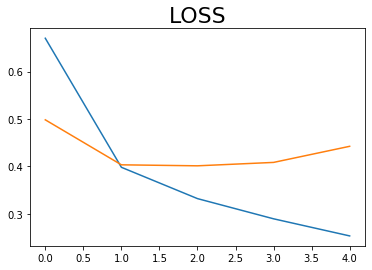

In [32]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS',fontdict={'size':'22'})
plt.plot()

[]

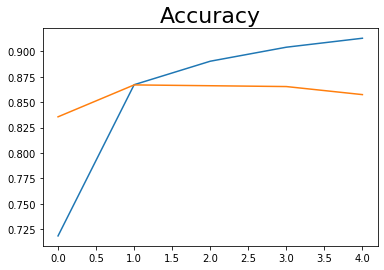

In [33]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Accuracy',fontdict={'size':'22'})
plt.plot()

<h1 style="background-color:lightblue;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Predicting on test dataset</h1>


In [34]:
test_data=pd.read_csv('Corona_NLP_test.csv',encoding='latin1')

In [35]:
test_data['Sentiment']=test_data['Sentiment'].replace({'Extremely Positive':'Positive','Extremely Negative':'Negative'})

In [36]:
test_label=lbl_encoder.transform(test_data['Sentiment'])

In [37]:
test_x=test_data.OriginalTweet

<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">By Process 1</h1>


In [38]:
test_x_1=tokenizer.transform(test_x).toarray()

In [39]:
print(classification_report(test_label,model_p1.predict(test_x_1)))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1633
           1       0.61      0.66      0.63       619
           2       0.79      0.81      0.80      1546

    accuracy                           0.77      3798
   macro avg       0.74      0.74      0.74      3798
weighted avg       0.77      0.77      0.77      3798



<h1 style="background-color:lightgreen;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">By Process 2</h1>


In [40]:
test_x_2=token.texts_to_sequences(test_data['OriginalTweet'])
test_x_2=pad_sequences(test_x_2,maxlen=60,padding='post',truncating='post')

In [41]:
print(classification_report(test_label,model.predict_classes(test_x_2)))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1633
           1       0.82      0.79      0.80       619
           2       0.83      0.90      0.87      1546

    accuracy                           0.85      3798
   macro avg       0.85      0.84      0.84      3798
weighted avg       0.85      0.85      0.85      3798



<h1 style="background-color:lightblue;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Conclusion</h1>


## Here both processes worked quite well though LSTM model worked better than linear model as Sequencial model understands data more efficiently and sequencially but that's not the case with linear model it just studies some common words and predict its output accordingly. So to use in daily practice for NLP Sequential model is mostly prefered.

<h1 style="background-color:pink;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px">If you liked this notebook . please upvote !!!</h1>


In [64]:
with open('lstm_model.pickle','wb') as handle:
    pickle.dump(model,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
with open('lstm_tokenizer.pickle','wb') as handle:
    pickle.dump(token,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
with open('encoder.pickle','wb') as handle:
    pickle.dump(lbl_encoder,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
# with open('tokenizer.pickle','rb') as handle:
#     t1=pickle.load(handle)

In [47]:
# m1=pickle.load(open('model.pkl','rb'))

In [48]:
# sentence='corona is destroying lives of many people'

In [59]:
# y=t1.texts_to_sequences([sentence])

In [61]:
# y=pad_sequences(y,maxlen=60,padding='post')

In [63]:
# m1.predict_classes(y)

array([1], dtype=int64)

In [62]:
# y

array([[211,  16,   1, 466,   9, 125,  35,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])